In [36]:
# Uneccessary on google colab
# %conda install pytorch torchvision -c pytorch
# %conda install -c fastai fastai

In [93]:
from fastai.vision.all import *
from fastcore.all import *
from sklearn.metrics import f1_score
from fastai.learner import Learner
from sklearn.metrics import f1_score




## Cat v dog single-label classification example

### Label dataset

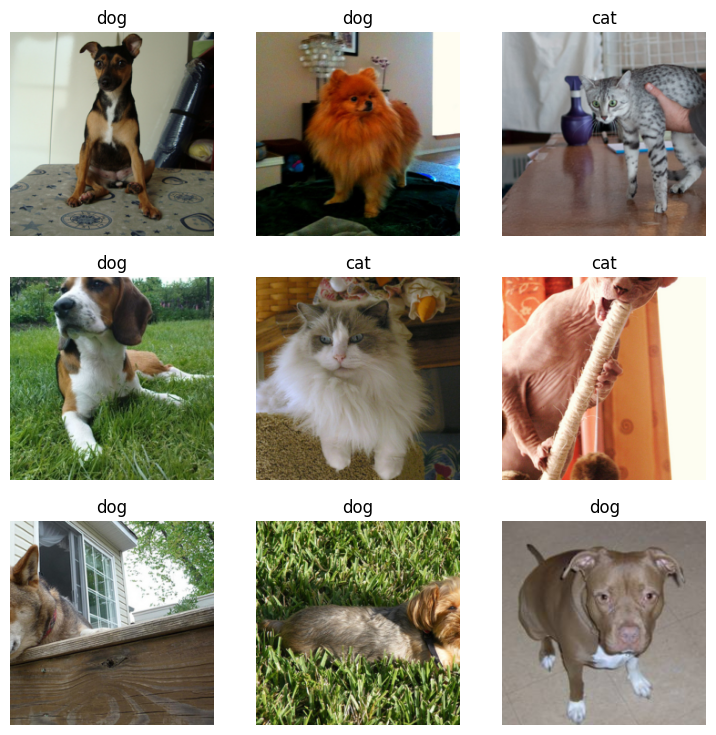

In [94]:
path = untar_data(URLs.PETS)
file_names = get_image_files(path/'images')

def label_func(filename):
    return "cat" if filename.name[0].isupper() else "dog"

dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))

dls = dblock.dataloaders(path/"images")
dls.show_batch()

### Retraining ResNet50 on new labeled dataset


---




In [95]:
learn = vision_learner(dls,  resnet50, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.142955,0.040055,0.017591,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.045457,0.009892,0.002706,01:08


### Test the performance of retrained model

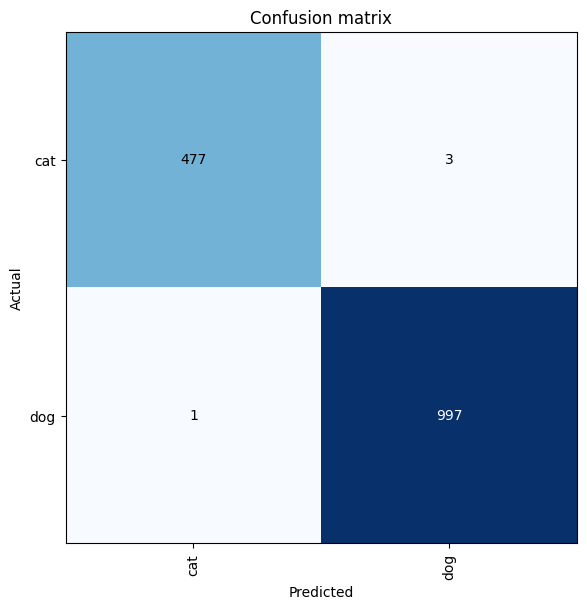

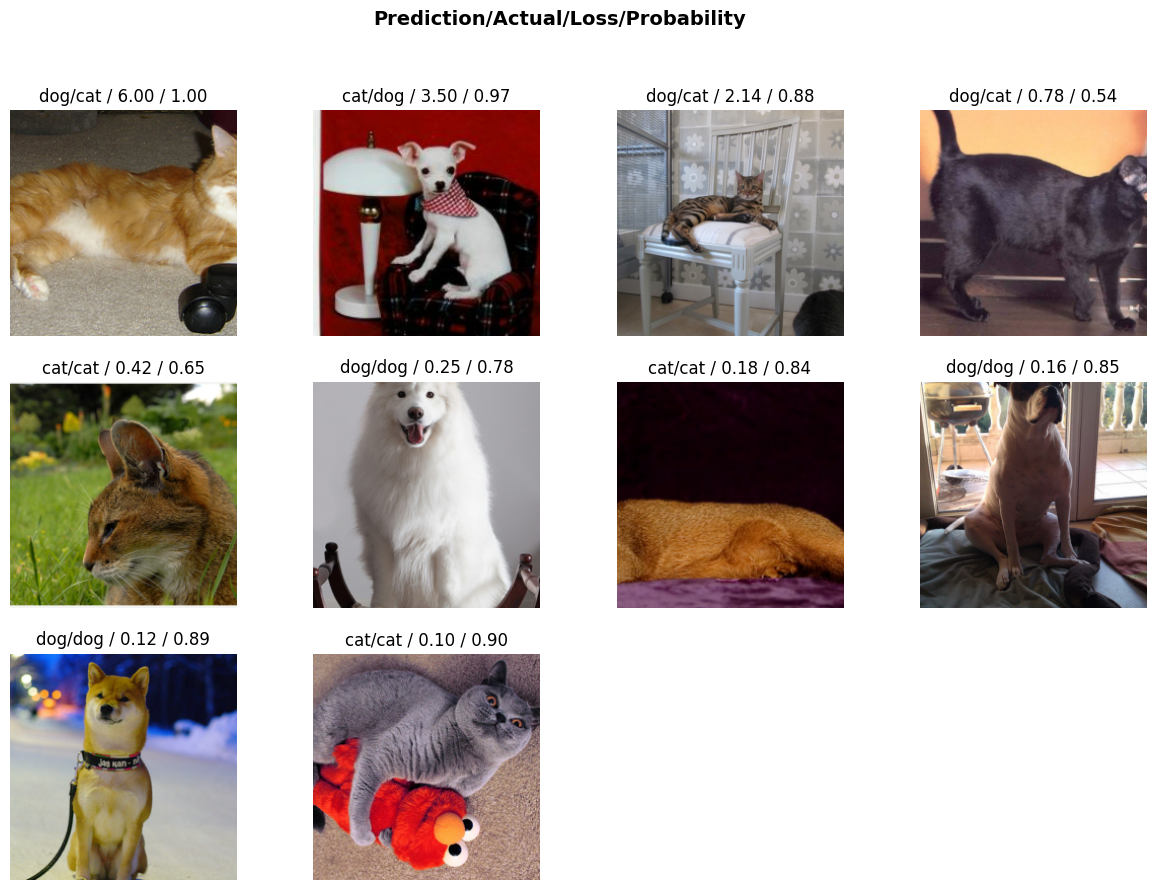

In [96]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))
interp.plot_top_losses(10, figsize=(15,10))

Predicted animal: cat.
Probability it is this animal: 0.000000


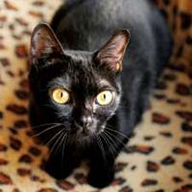

In [97]:
img = PILImage.create(file_names[9])

prediction,_,probs = learn.predict(img)

print(f"Predicted animal: {prediction}.")
print(f"Probability it is this animal: {probs[1].item():.6f}")
img.to_thumb(192)

## Retrain for single-label Chest cancer classification

In [98]:
!git clone https://github.com/davay/data5100.git

fatal: destination path 'data5100' already exists and is not an empty directory.


### Label and load images

In [99]:
path = 'data5100/data'
dls = ImageDataLoaders.from_folder(path,
                            train = 'train',
                            valid = 'valid',
                            test = 'test',
                            item_tfms = Resize(224, pad_mode='zeros'), # imagenet models often use 224 x 224. Our images aren't 1:1 aspect ratio, by default center crop will be used. We can add pad_mode='zeros' for no cropping.
                            batch_tfms=aug_transforms()) # testing default augmentations

### Test the accuracy of stock imagenet model

In [100]:
# TODO: IN PROGRESS

# model = resnet34(pretrained = True)

# # switch to evaluation mode for inference rather than training
# model.eval()

### Retrain model on new data set

In [101]:
learn = vision_learner(dls,  resnet50, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,2.099822,1.856695,0.541667,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.274998,1.313115,0.500000,00:08


### Test the accuracy of retrained model

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,1.910097,1.719986,0.597222,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.100441,1.152903,0.416667,00:07


F1 Score: 0.5987369337979094


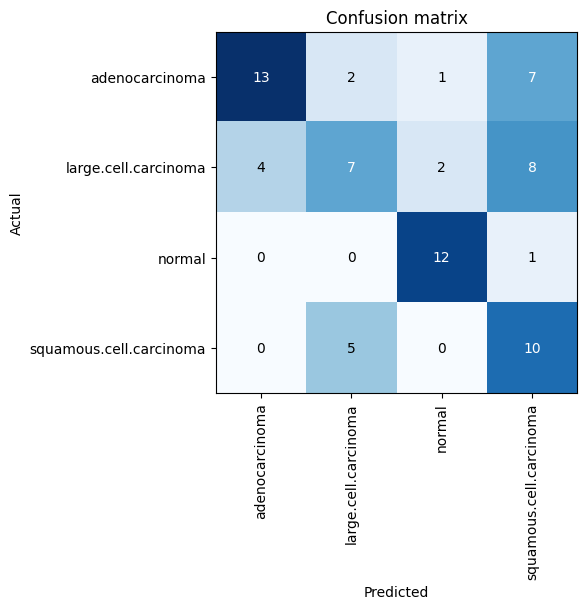

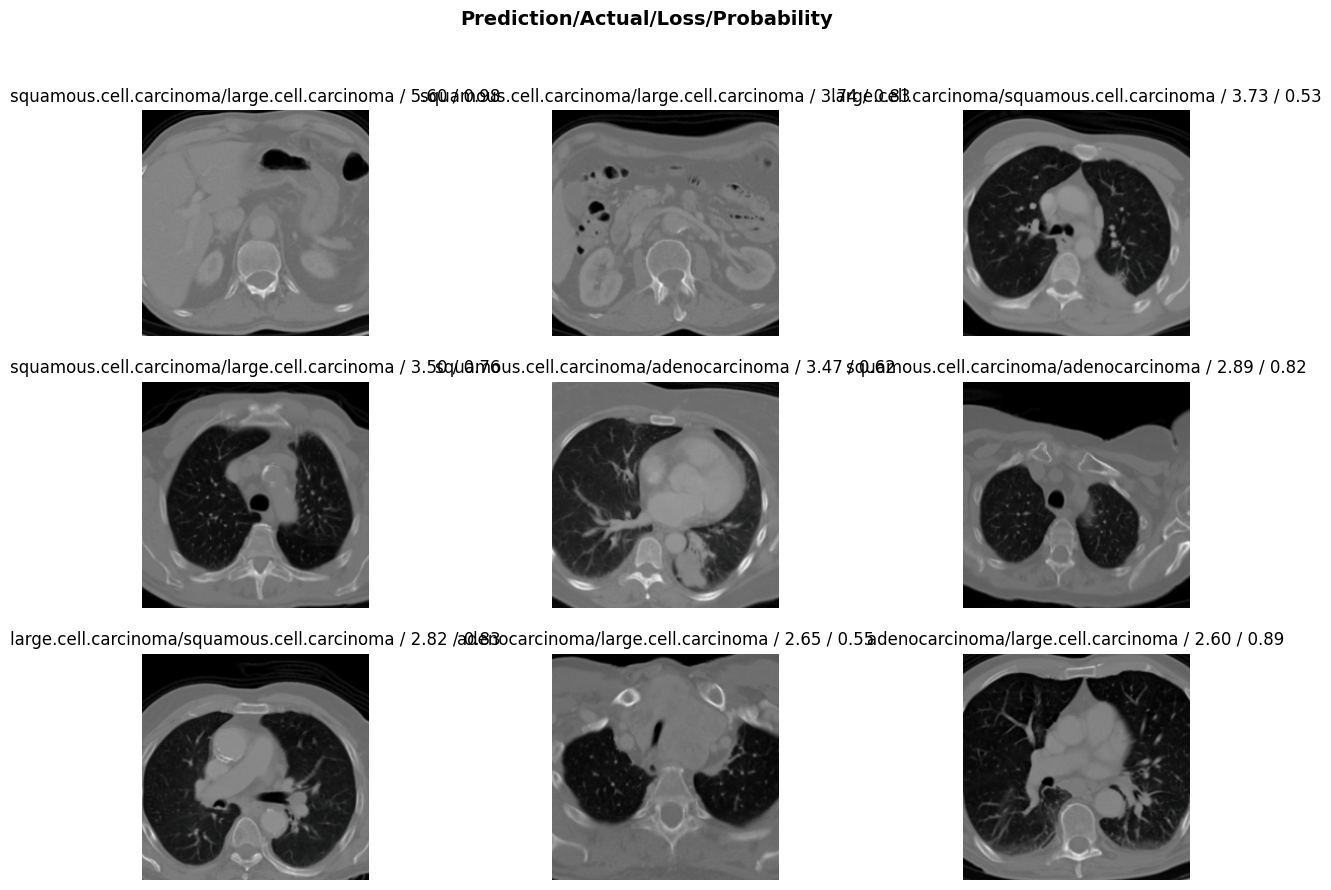

In [108]:

# Define a custom F1 score metric for Fastai
f1score_fastai = skm_to_fastai(f1_score, average='macro')

# Assuming dls is your data loader and learn is your trained model
learn = cnn_learner(dls, resnet50, metrics=[error_rate])
learn.fine_tune(1)

# Append the F1 score metric
learn.metrics.append(f1score_fastai)

# Validate and print F1 Score
val_loss = learn.validate()[0]
val_f1score = learn.recorder.values[-1][2]  # Index 2 corresponds to the F1 score

print(f"F1 Score: {val_f1score}")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))
interp.plot_top_losses(9, figsize=(15,10))


Predicted picture: adenocarcinoma.
Probability: 0.022387


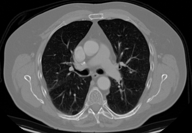

In [103]:
file_names = get_image_files(path)
img = PILImage.create(file_names[random.randint(0, len(file_names)) - 1])

prediction,_,probs = learn.predict(img)

print(f"Predicted picture: {prediction}.")
print(f"Probability: {probs[1].item():.6f}")
img.to_thumb(192)